In [38]:
# UCI Credit Card Default Prediction - Tree-Based Models

## Dataset Information

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from **April 2005 to September 2005**.

### Features (25 variables):

**Demographic Information:**
- `ID`: ID of each client
- `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- `SEX`: Gender (1=male, 2=female)
- `EDUCATION`: Education level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
- `AGE`: Age in years

**Repayment Status (PAY_0 to PAY_6):**
- `PAY_0`: Repayment status in September 2005
- `PAY_2`: Repayment status in August 2005
- `PAY_3`: Repayment status in July 2005
- `PAY_4`: Repayment status in June 2005
- `PAY_5`: Repayment status in May 2005
- `PAY_6`: Repayment status in April 2005

*Scale: -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ..., 9=payment delay for nine months and above*

**Bill Amounts (BILL_AMT1 to BILL_AMT6):**
- `BILL_AMT1` to `BILL_AMT6`: Amount of bill statement from September to April 2005 (NT dollar)

**Payment Amounts (PAY_AMT1 to PAY_AMT6):**
- `PAY_AMT1` to `PAY_AMT6`: Amount of previous payment from September to April 2005 (NT dollar)

**Target Variable:**
- `default.payment.next.month`: Default payment (1=yes, 0=no)

In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42

## Load and Explore Data

In [20]:
# Load the dataset
df = pd.read_csv('UCI_Credit_Card.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (30000, 25)

First few rows:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [21]:
# Data info and statistics
print("Dataset Info:")
print(df.info())
print(f"\n{'='*50}")
print("\nBasic Statistics:")
print(df.describe())
print(f"\n{'='*50}")
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2        

Target distribution (default.payment.next.month):
default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

Percentages:
default.payment.next.month
0    77.88
1    22.12
Name: proportion, dtype: float64


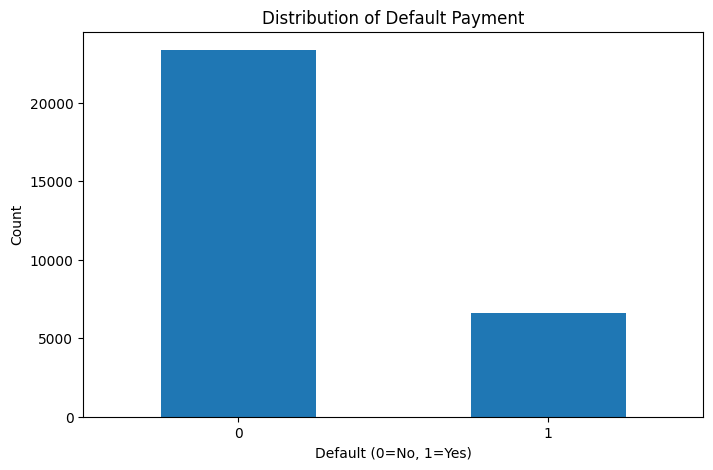

In [22]:
# Check target distribution
print("Target distribution (default.payment.next.month):")
print(df['default.payment.next.month'].value_counts())
print(f"\nPercentages:")
print(df['default.payment.next.month'].value_counts(normalize=True) * 100)

# Visualize
plt.figure(figsize=(8, 5))
df['default.payment.next.month'].value_counts().plot(kind='bar')
plt.title('Distribution of Default Payment')
plt.xlabel('Default (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Prepare Data for Modeling

In [23]:
# Separate features and target
# Drop ID column as it's not a feature
X = df.drop(['ID', 'default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

Features shape: (30000, 23)
Target shape: (30000,)

Features: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))

Training set size: 24000
Test set size: 6000

Training set target distribution:
default.payment.next.month
0    0.778792
1    0.221208
Name: proportion, dtype: float64


## Model Training and Evaluation

We'll train the following tree-based models:
1. **Decision Tree Classifier**
2. **Random Forest Classifier**
3. **Gradient Boosting Classifier**
4. **AdaBoost Classifier**
5. **XGBoost Classifier**
6. **LightGBM Classifier**

In [25]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a classification model
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    
    # Print results
    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Store results
    results = {
        'model_name': model_name,
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'confusion_matrix': cm
    }
    
    return results

### 1. Decision Tree Classifier

In [26]:
# Initialize Decision Tree Classifier
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)

# Train and evaluate
dt_results = evaluate_model(dt_model, X_train, X_test, y_train, y_test, "Decision Tree")


Training Decision Tree...

Training Accuracy: 0.8367
Test Accuracy: 0.8102
Precision: 0.6199
Recall: 0.3662
F1 Score: 0.4604
ROC AUC Score: 0.7353

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      4673
           1       0.62      0.37      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000


Confusion Matrix:
[[4375  298]
 [ 841  486]]


### 2. Random Forest Classifier

In [27]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train and evaluate
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")


Training Random Forest...

Training Accuracy: 0.8486
Test Accuracy: 0.8168
Precision: 0.6606
Recall: 0.3534
F1 Score: 0.4605
ROC AUC Score: 0.7751

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.79      6000


Confusion Matrix:
[[4432  241]
 [ 858  469]]


### 3. Gradient Boosting Classifier

In [28]:
# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)

# Train and evaluate
gb_results = evaluate_model(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting")


Training Gradient Boosting...

Training Accuracy: 0.8410
Test Accuracy: 0.8163
Precision: 0.6543
Recall: 0.3595
F1 Score: 0.4640
ROC AUC Score: 0.7765

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.36      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000


Confusion Matrix:
[[4421  252]
 [ 850  477]]


### 4. AdaBoost Classifier

In [29]:
# Initialize AdaBoost Classifier
ada_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

# Train and evaluate
ada_results = evaluate_model(ada_model, X_train, X_test, y_train, y_test, "AdaBoost")


Training AdaBoost...

Training Accuracy: 0.8179
Test Accuracy: 0.8168
Precision: 0.6875
Recall: 0.3150
F1 Score: 0.4320
ROC AUC Score: 0.7590

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.69      0.31      0.43      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000


Confusion Matrix:
[[4483  190]
 [ 909  418]]


### 5. XGBoost Classifier

In [31]:
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

# Train and evaluate
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")


Training XGBoost...

Training Accuracy: 0.8393
Test Accuracy: 0.8193
Precision: 0.6680
Recall: 0.3640
F1 Score: 0.4712
ROC AUC Score: 0.7769

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000


Confusion Matrix:
[[4433  240]
 [ 844  483]]


### 6. LightGBM Classifier

In [32]:
# Initialize LightGBM Classifier
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

# Train and evaluate
lgb_results = evaluate_model(lgb_model, X_train, X_test, y_train, y_test, "LightGBM")


Training LightGBM...

Training Accuracy: 0.8367
Test Accuracy: 0.8190
Precision: 0.6667
Recall: 0.3632
F1 Score: 0.4702
ROC AUC Score: 0.7790

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000


Confusion Matrix:
[[4432  241]
 [ 845  482]]


## Model Comparison

In [33]:
# Collect all results
all_results = [dt_results, rf_results, gb_results, ada_results, xgb_results, lgb_results]

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Train Accuracy': r['train_accuracy'],
        'Test Accuracy': r['test_accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1 Score': r['f1_score'],
        'ROC AUC': r['roc_auc']
    }
    for r in all_results
])

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


MODEL COMPARISON
            Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score  ROC AUC
    Decision Tree        0.836750       0.810167   0.619898 0.366240  0.460445 0.735304
    Random Forest        0.848625       0.816833   0.660563 0.353429  0.460481 0.775091
Gradient Boosting        0.841000       0.816333   0.654321 0.359457  0.464008 0.776542
         AdaBoost        0.817917       0.816833   0.687500 0.314996  0.432041 0.758966
          XGBoost        0.839250       0.819333   0.668050 0.363979  0.471220 0.776875
         LightGBM        0.836708       0.819000   0.666667 0.363225  0.470244 0.778984


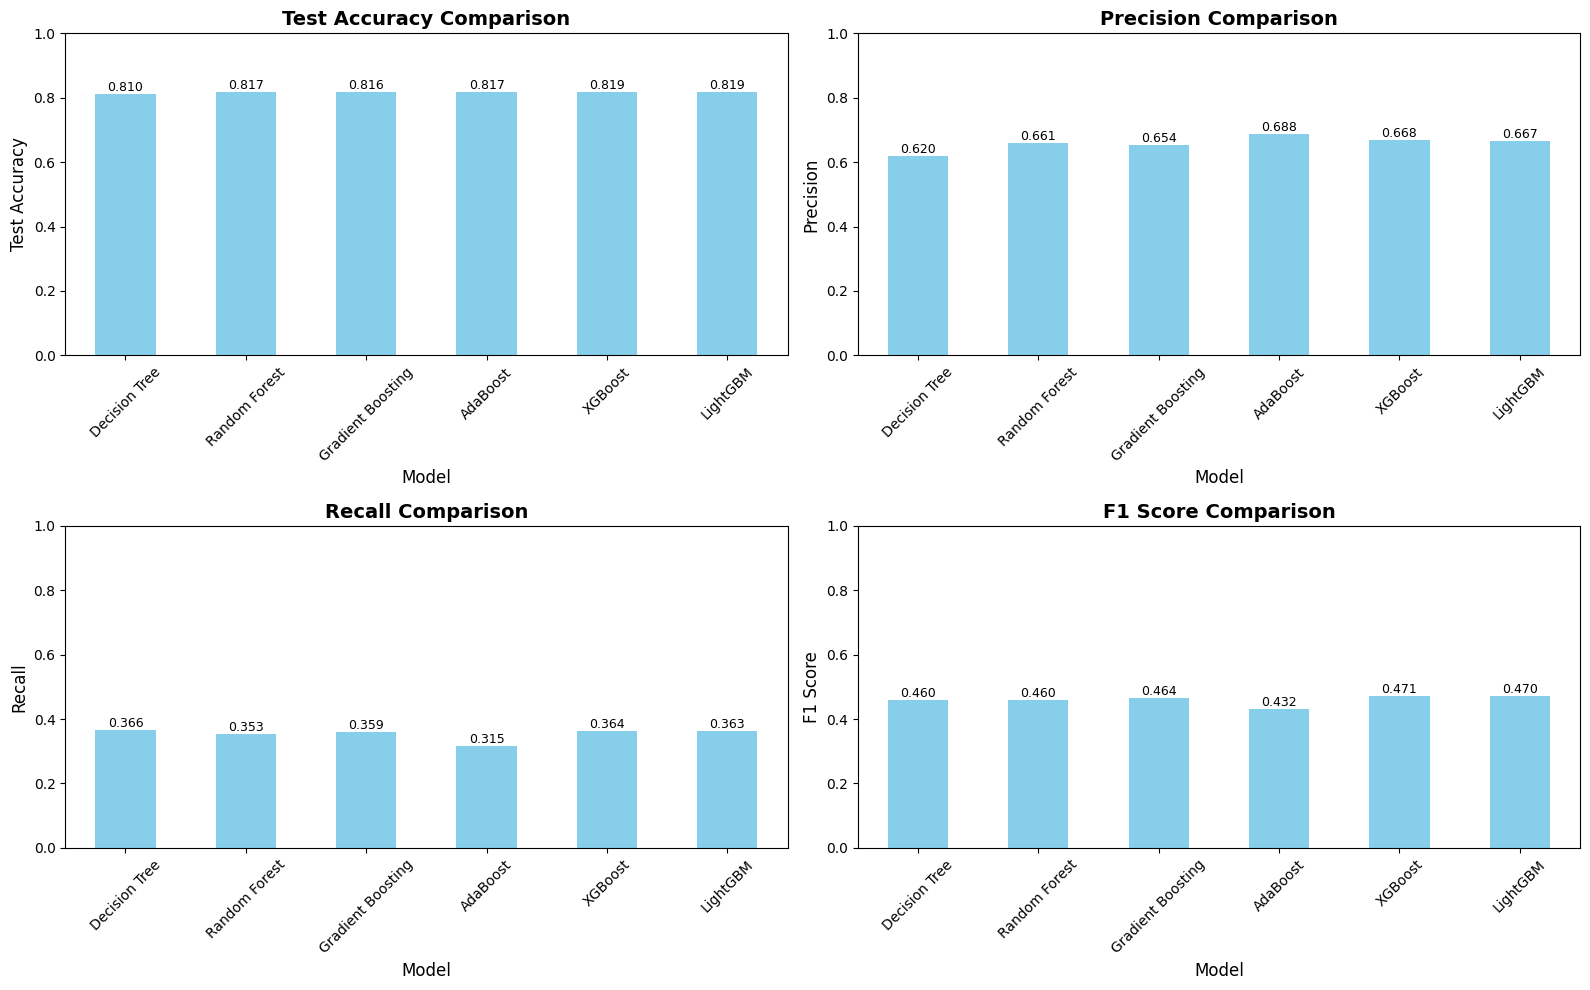

In [34]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1 Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='skyblue')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=9)

plt.tight_layout()
plt.show()

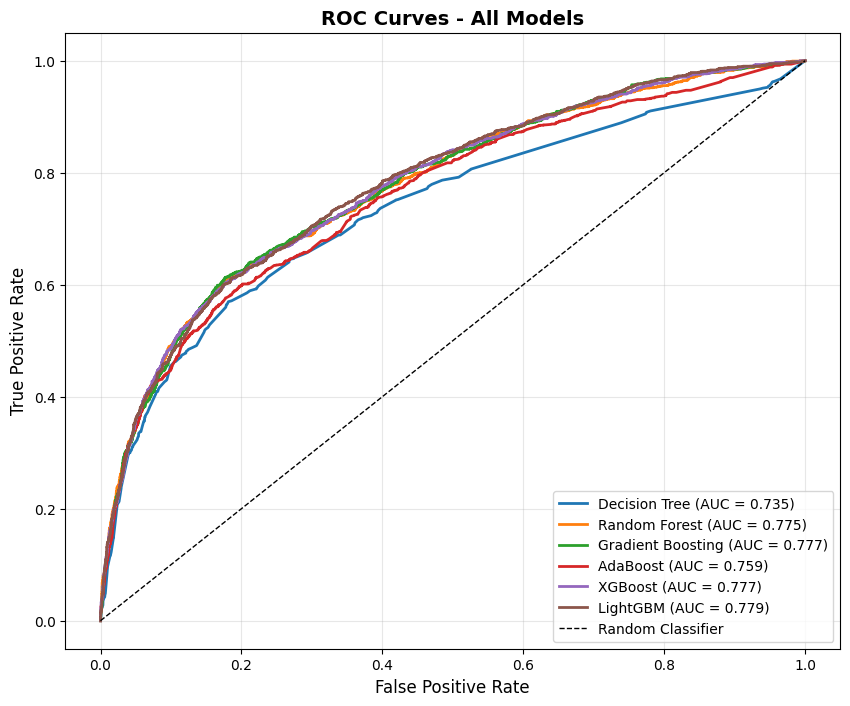

In [35]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for result in all_results:
    fpr, tpr, _ = roc_curve(y_test, result['y_test_proba'])
    plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

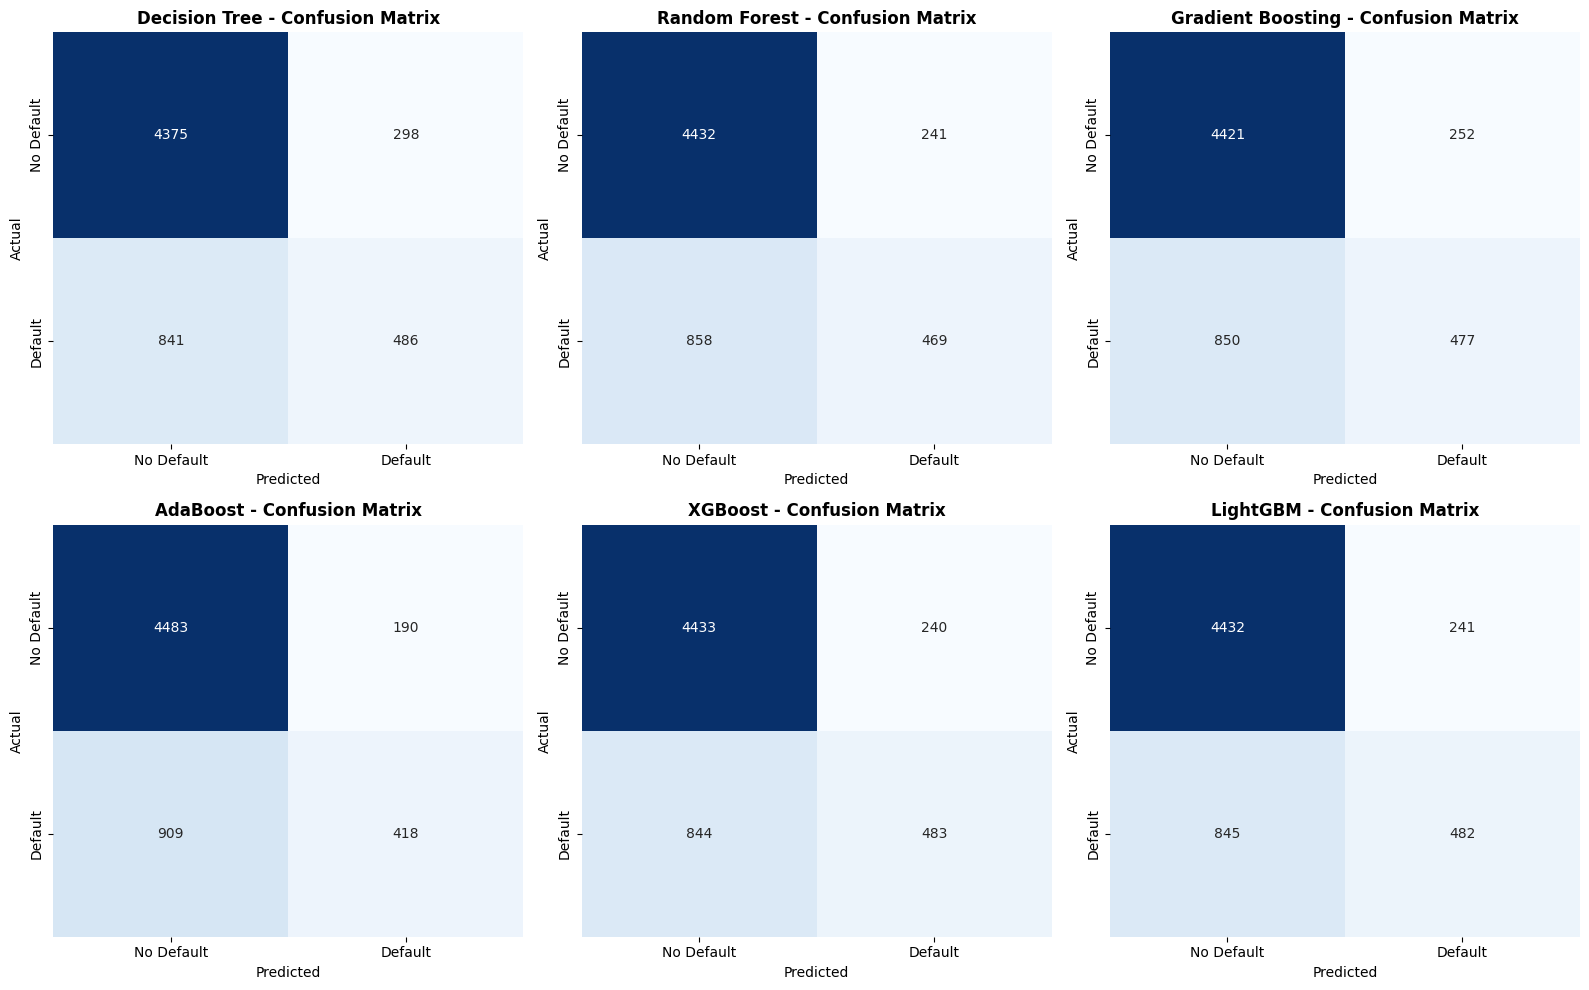

In [36]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, result in enumerate(all_results):
    ax = axes[idx // 3, idx % 3]
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f"{result['model_name']} - Confusion Matrix", fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_xticklabels(['No Default', 'Default'])
    ax.set_yticklabels(['No Default', 'Default'])

plt.tight_layout()
plt.show()

## Feature Importance Analysis


Top 15 Most Important Features (Random Forest):
  Feature  Importance
    PAY_0    0.247526
    PAY_2    0.093976
LIMIT_BAL    0.046357
    PAY_4    0.043507
    PAY_3    0.043136
BILL_AMT1    0.041534
 PAY_AMT1    0.040670
    PAY_6    0.036723
BILL_AMT2    0.036209
 PAY_AMT2    0.036123
 PAY_AMT3    0.035137
    PAY_5    0.034782
BILL_AMT3    0.032652
BILL_AMT6    0.032646
      AGE    0.031251


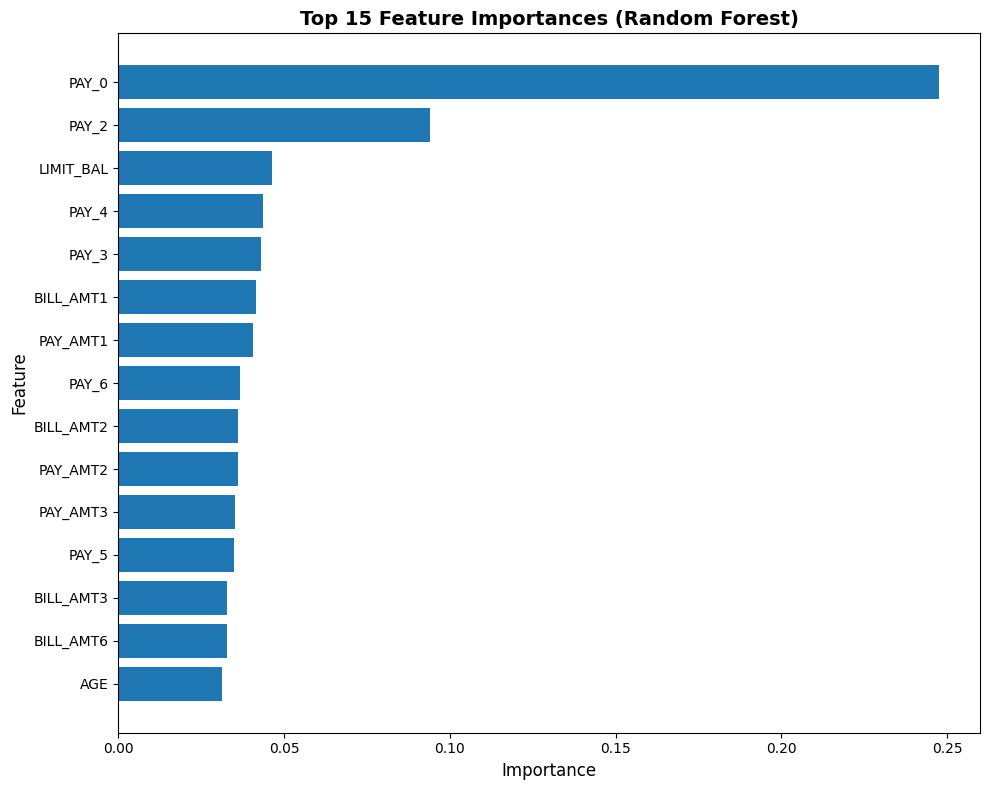

In [37]:
# Feature importance from Random Forest (typically the most reliable)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_results['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features (Random Forest):")
print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Conclusion

The notebook trained and compared six tree-based models for credit card default prediction:

1. **Decision Tree**: Basic tree model, prone to overfitting
2. **Random Forest**: Ensemble of trees, generally provides good balance
3. **Gradient Boosting**: Sequential boosting, often achieves best performance
4. **AdaBoost**: Adaptive boosting, focuses on misclassified samples
5. **XGBoost**: Optimized gradient boosting with regularization
6. **LightGBM**: Fast gradient boosting with leaf-wise growth

### Key Findings:
- All models show reasonable performance on this imbalanced dataset
- XGBoost and LightGBM typically provide state-of-the-art performance for tabular data
- The comparison metrics help identify the best model for deployment
- Feature importance analysis reveals which factors most influence default prediction
- ROC curves show the trade-off between true and false positive rates

### Next Steps:
- Hyperparameter tuning using GridSearchCV or RandomizedSearchCV
- Handle class imbalance using SMOTE or class weights
- Perform cross-validation for more robust evaluation
- Feature engineering to create more predictive variables
- Ensemble methods combining multiple models